In [1]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass


Number of available GPUs: 1


# Parameters

In [2]:
BATCH_SIZE = 256
EPOCHS = 100
TEST_SPLIT = 0.2
VALID_SPLIT = 0.1
SEED = 7321
VOCABULARY_SIZE = 100_000
MAX_SEQUENCE_LEN = 250
EMBEDDING_DIM = 75

# Loading dataset

In [3]:
SRC_DIR = Path(abspath('')).parent.parent
RAW_DIR = SRC_DIR / "raw"
DATASET_DIR = str((RAW_DIR / "dataset").resolve())
BEST_MODEL_DIR = RAW_DIR / "checkpoints"
TENSOR_BOARD_DIR = RAW_DIR / "tensor_board"

train_ds, test_ds = tf.keras.utils.text_dataset_from_directory(
    directory=DATASET_DIR,
    label_mode='categorical',
    validation_split=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='both',
)
val_ds_size = int(test_ds.cardinality().numpy() * VALID_SPLIT)
val_ds = test_ds.take(val_ds_size)
test_ds = test_ds.skip(val_ds_size)

Found 1438 files belonging to 3 classes.
Using 1151 files for training.
Using 287 files for validation.
Metal device set to: Apple M1 Max


2022-12-12 18:37:32.156230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 18:37:32.156410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Instantiate words vectorizing layer

In [4]:
train_text = train_ds.map(lambda x, y: x)

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN
)
vectorize_layer.adapt(train_text, batch_size=BATCH_SIZE)

2022-12-12 18:37:32.273881: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 18:37:32.311622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Batch, cache, autotune

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1500).prefetch(AUTOTUNE)
test_ds = test_ds.cache().shuffle(1500).prefetch(AUTOTUNE)
val_ds = val_ds.cache().shuffle(1500).prefetch(AUTOTUNE)

list(train_ds.as_numpy_iterator())
list(test_ds.as_numpy_iterator())
list(val_ds.as_numpy_iterator())
print("Dataset cached successfully!")

Dataset cached successfully!


# Build model

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1028, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 75)           7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 2056)        9079296   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              2237440   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                        

## Compile the model

In [7]:
import tensorflow_addons as tfa

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC(),
        # tfa.metrics.F1Score(num_classes=3)
    ]
)

## Model callbacks

In [8]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "lstm7_best1"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, verbose=1, min_delta=0.001)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=BEST_MODEL_FILE/"history_7_1.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

# Fit the model

In [9]:
%load_ext tensorboard
%tensorboard --logdir /Users/wiktorpieklik/studies/2sem/uczenie_glebokie/projekt/raw/tensor_board

Launching TensorBoard...

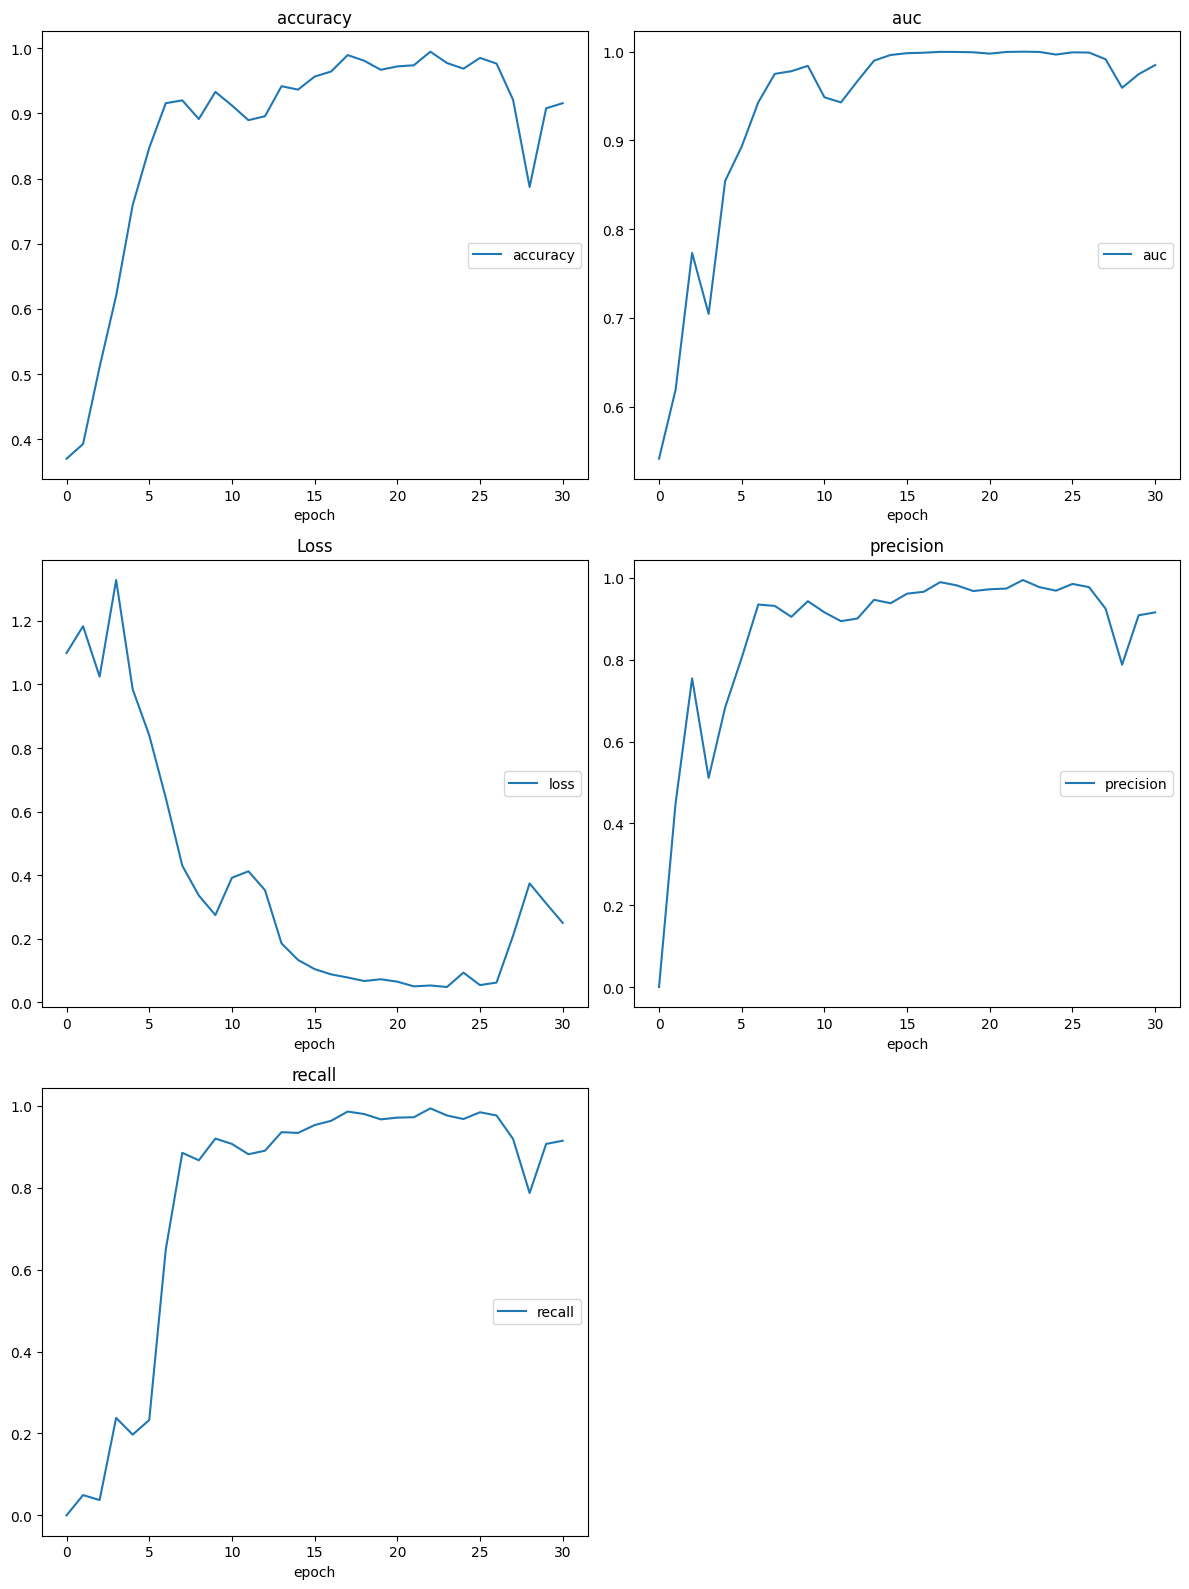

accuracy
	accuracy         	 (min:    0.370, max:    0.995, cur:    0.916)
auc
	auc              	 (min:    0.541, max:    1.000, cur:    0.985)
Loss
	loss             	 (min:    0.047, max:    1.329, cur:    0.249)
precision
	precision        	 (min:    0.000, max:    0.995, cur:    0.916)
recall
	recall           	 (min:    0.000, max:    0.994, cur:    0.915)
5/5 [==============================] - 13s 3s/step - loss: 0.2494 - accuracy: 0.9157 - recall: 0.9149 - precision: 0.9157 - auc: 0.9848
Epoch 31: early stopping


In [10]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[save_best, early_stop, csv_logger, tensorboard_cb, PlotLossesKeras()],
    )

# Evaluate the model

In [11]:
model.evaluate(test_ds)

2022-12-12 18:46:44.649874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 18:46:44.771390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 18:46:44.779716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 18:46:45.445531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 18:46:45.456888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step - loss: 0.8881 - accuracy: 0.7213 - recall: 0.7213 - precision: 0.7213 - auc: 0.8587


[0.8880682587623596,
 0.7212543487548828,
 0.7212543487548828,
 0.7212543487548828,
 0.8587241768836975]